In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import csv

import tensorflow as tf
import keras
from keras import backend as K
#print(K.image_data_format())
K.set_image_data_format('channels_first')

from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model

from utils.data.load_data import get_UKB_dataset
from utils.params import TRAIN_RATIO, VAL_RATIO
from utils.data.preprocessing_utils import load_ukb_fundus_img
from utils.data.preprocess import get_preprocess_fn

from tables import *

import collections
from PIL import Image
import os

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
dnn_type = 'bagnet33'
model_dir = '/gpfs01/berens/user/iilanchezian/Projects/UKbiobank/supervised/modelstore/%s/' % (dnn_type)
model_filename = 'UKB_genderNet_bagnet33_imagenet_098_0.835.hdf5'

model_filepath = os.path.join(model_dir, model_filename)
bagnet = load_model(model_filepath)
print('========================================================================')
print('BagNet')
bagnet.summary()
print('========================================================================')

# feature extractor 
feature_extractor = Model(inputs=bagnet.input, outputs=bagnet.get_layer('layer4.2.relu0.23004603898000509').output)
for layer in feature_extractor.layers:
    layer.trainable = False
print('========================================================================')
print('Feature Extractor')
feature_extractor.summary()
print('========================================================================')

feature_vector = Input(shape=(2048,))
logits = bagnet.get_layer('dense_1')(feature_vector)
softmax = bagnet.get_layer('activation_1')(logits)

logit_machine = Model(inputs=feature_vector, outputs=logits)
for layer in logit_machine.layers:
    layer.trainable = False
print('========================================================================')
print('Logit Machine')
logit_machine.summary()
print('========================================================================')

lin_classifier = Model(inputs=feature_vector, outputs=softmax)
for layer in lin_classifier.layers:
    layer.trainable = False
print('========================================================================')    
print('Linear Classifier')
lin_classifier.summary()
print('========================================================================')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

BagNet
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             (None, 3, 224, 224)  0                                            
__________________________________________________________________________________________________
conv10.275406533888118 (Conv2D) (None, 64, 224, 224) 192         input0[0][0]                     
__________________________________________________________________________________________________
conv20.7357471192702366 (Conv2D (None, 64, 222, 222) 36864       conv10.275406533888118[0][0]     
__________________________________________________________________________________________________
bn10.3729843759042565 (BatchNor (None, 64, 222, 222) 256         conv20.7357471192702366[

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [4]:
# img_dir = '/gpfs01/berens/data/data/biobank/ukb_fundus_224/'
# storage_dir = '/gpfs01/berens/user/iilanchezian/Projects/UKbiobank/supervised/patch_features/'
# train_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_train_v4.h5')
# val_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_val_v4.h5')
# test_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_test_v4.h5')

# def filter_patches(h5filename, qual_threshold, condition):
#     h5file = open_file(h5filename)
#     patch_table = h5file.root.patch.patchinfo
#     patch_info = [patch['filename'] for patch in 
#                patch_table.where(condition)]
#     print('Done')
#     return patch_info

# quality_threshold = 0.5

# condition1 = """(global_quality < qual_threshold) & (true_label == 0) & (predicted_label == true_label)"""
# condition2 = """(global_quality < qual_threshold) & (true_label == 1) & (predicted_label == true_label)"""

# %time female_patches = filter_patches(test_fname, quality_threshold, condition1)
# %time male_patches = filter_patches(test_fname, quality_threshold, condition2)

# np.save('patch_data/bg33_test_patches_female.npy', np.unique(female_patches))
# np.save('patch_data/bg33_test_patches_male.npy', np.unique(male_patches))

Done
CPU times: user 3.67 s, sys: 2.27 s, total: 5.94 s
Wall time: 19.8 s
Done
CPU times: user 3.09 s, sys: 1.97 s, total: 5.06 s
Wall time: 12.8 s


In [7]:
female_patches = np.load('patch_data/bg33_test_patches_female.npy')
male_patches = np.load('patch_data/bg33_test_patches_male.npy')

In [8]:
female_patches = np.unique(female_patches)
print('Total female fundus images: %d'%(len(female_patches)))
female_left_patches = [patch for patch in female_patches if b'21015' in patch]
print('Female fundus images of left eye: %d'%(len(female_left_patches)))
female_right_patches = [patch for patch in female_patches if b'21016' in patch]
print('Female fundus images of right eye: %d'%(len(female_right_patches)))

male_patches = np.unique(male_patches)
print('Total male fundus images: %d'%(len(male_patches)))
male_left_patches = [patch for patch in male_patches if b'21015' in patch]
print('Male fundus images of left eye: %d'%(len(male_left_patches)))
male_right_patches = [patch for patch in male_patches if b'21016' in patch]
print('Male fundus images of right eye: %d'%(len(male_right_patches)))

Total female fundus images: 3310
Female fundus images of left eye: 1598
Female fundus images of right eye: 1713
Total male fundus images: 2779
Male fundus images of left eye: 1296
Male fundus images of right eye: 1483


In [9]:
import matplotlib
from matplotlib.collections import PatchCollection
from scipy.special import expit

def get_avg_image(patches):
    images = np.zeros(shape=(len(patches), 224, 224, 3))
    for i, patch in enumerate(patches):
        filename = patch.decode("utf-8")
        path = os.path.join(img_dir, filename)
        with Image.open(path) as img:
            img = np.array(img)
            
        images[i, :, :, :] = img
        
    img_avg = np.mean(images, axis=0)
    return img_avg

def get_heatmap_for_img(patch, gender_idx, patches_per_image=24*24):
    filename = patch.decode("utf-8")
    path = os.path.join(img_dir, filename)
    with Image.open(path) as img:
        img = np.asarray(img, dtype=np.int32)
        
    dnn_type='bagnet33'
    preprocess_fn = get_preprocess_fn(dnn_type)
        
    img_proc = load_ukb_fundus_img(path=path, data_aug=None, mask=True,
                                   subtract_bg=False, kernel='median',
                                   ksize=23, channel_first=True,
                                   preprocessing_function=preprocess_fn)
    
    features = feature_extractor.predict(img_proc)[0]
    my_batch = np.transpose(np.reshape(features, newshape=(features.shape[0], -1)))
    
    heatmap = logit_machine.predict(my_batch)#[:,gender_idx]
    heatmap = np.reshape(heatmap, newshape=(features.shape[-2],features.shape[-1]))
    
    return img, heatmap 

def get_heatmap_avg(patches, gender_idx, patches_per_image=24*24):
    dnn_type='bagnet33'
    preprocess_fn = get_preprocess_fn(dnn_type)
    
    heatmap_all = np.zeros(shape=(len(patches), 24, 24))
    
    for i, patch in enumerate(patches):
        filename = patch.decode("utf-8")
        path = os.path.join(img_dir, filename)
        with Image.open(path) as img:
            img = np.asarray(img, dtype=np.int32)
        
  
        
        img_proc = load_ukb_fundus_img(path=path, data_aug=None, mask=True, 
                                       subtract_bg=False, kernel='median',
                                       ksize=23, channel_first=True,
                                       preprocessing_function=preprocess_fn)
        
        features = feature_extractor.predict(img_proc)[0]
        my_batch = np.transpose(np.reshape(features, newshape=(features.shape[0], -1)))
        
        heatmap = logit_machine.predict(my_batch)#[:,gender_idx]
        heatmap = np.reshape(heatmap, newshape=(features.shape[-2],features.shape[-1]))
        
        
        heatmap_all[i, :, :] = heatmap

    heatmap_avg = np.mean(heatmap_all, axis=0)

    return heatmap_avg

In [10]:
hm_female_left = get_heatmap_avg(female_left_patches, gender_idx=0)
hm_female_right = get_heatmap_avg(female_right_patches, gender_idx=0)
hm_male_left = get_heatmap_avg(male_left_patches, gender_idx=1)
hm_male_right = get_heatmap_avg(male_right_patches, gender_idx=1)

# print(hm_female_left.shape)
# print(hm_female_right.shape)
# print(hm_male_left.shape)
# print(hm_male_right.shape)

In [11]:
female_left = get_avg_image(female_left_patches)
female_right = get_avg_image(female_right_patches)
male_left = get_avg_image(male_left_patches)
male_right = get_avg_image(male_right_patches)

# print(female_left.shape)
# print(female_right.shape)
# print(male_left.shape)
# print(male_right.shape)

In [12]:
#Example male image
patch_male = male_right_patches[3]
male_image, male_heatmap_example = get_heatmap_for_img(patch_male, gender_idx=1)

#Example female image 
patch_female = female_left_patches[81]
female_image, female_heatmap_example = get_heatmap_for_img(patch_female, gender_idx=0)

In [13]:
import matplotlib.colors as mpc

def plot_heatmap(ax, hm, v=75):
    cmap = ax.imshow(hm, cmap='coolwarm', norm=mpc.Normalize(vmin=-1*v, vmax=v, clip=True))
    ax.set_xticks([])
    ax.set_yticks([])
    return cmap

def plot_image(ax, image):
    image = image / 255.
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

In [14]:
def set_rcParams():
    sns.set_context('paper')
    sns.set_style('ticks')
    plt.rcParams['axes.linewidth']    = .7
    plt.rcParams['xtick.major.width'] = .5
    plt.rcParams['ytick.major.width'] = .5
    plt.rcParams['xtick.minor.width'] = .5
    plt.rcParams['ytick.minor.width'] = .5
    plt.rcParams['xtick.major.size'] = 2
    plt.rcParams['ytick.major.size'] = 2
    plt.rcParams['xtick.minor.size'] = 1
    plt.rcParams['ytick.minor.size'] = 1
    plt.rcParams['font.size']       = 8
    plt.rcParams['axes.titlesize']  = 10 
    plt.rcParams['axes.labelsize']  = 8
    plt.rcParams['legend.fontsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['figure.facecolor']=(0.5,0.5,0.5,0.5) # only affects the notebook
    plt.rcParams['savefig.facecolor']=(1,1,1,0)
    plt.rcParams["savefig.dpi"] = 1200
    plt.rcParams['font.family'] = "Arial"
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams['figure.dpi'] = 120     # only affects the notebook
set_rcParams()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


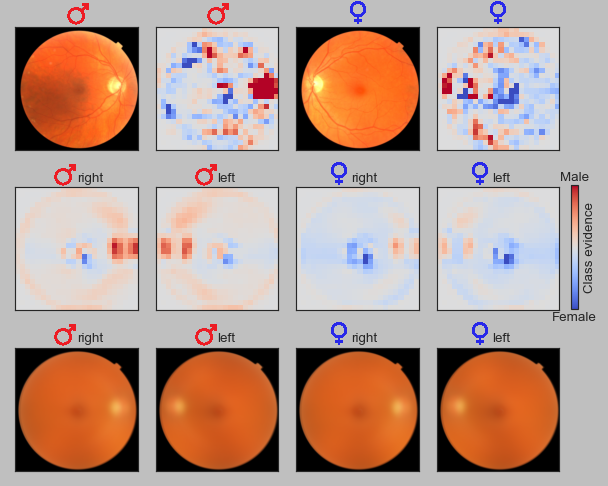

In [15]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig = plt.figure(figsize=(4.8, 4.2))
gs = fig.add_gridspec(3,4, wspace=0.05, hspace=0.025)

male_icon = plt.imread('images/male.png')
female_icon = plt.imread('images/female.png')

male_img = OffsetImage(male_icon, zoom=0.025)
female_img = OffsetImage(female_icon, zoom=0.025)

ax_male_ex = fig.add_subplot(gs[0,0])
ax_male_ex.imshow(male_image)
ax_male_ex.set_xticks([])
ax_male_ex.set_yticks([])
ab_1 = AnnotationBbox(male_img, (0.5, 1.1075), xycoords=ax_male_ex.transAxes, frameon=False)
ax_male_ex.text(0.5, 1.05, '   ', transform=ax_male_ex.transAxes)
ax_male_ex.add_artist(ab_1)

ax_male_hm = fig.add_subplot(gs[0,1])
plot_heatmap(ax_male_hm, male_heatmap_example)
ab_2 = AnnotationBbox(male_img, (0.5, 1.1075), xycoords=ax_male_hm.transAxes, frameon=False)
ax_male_hm.add_artist(ab_2)

ax_female_ex = fig.add_subplot(gs[0,2])
ax_female_ex.imshow(female_image)
ax_female_ex.set_xticks([])
ax_female_ex.set_yticks([])
ab_3 = AnnotationBbox(female_img, (0.5, 1.1125), xycoords=ax_female_ex.transAxes, frameon=False)
ax_female_ex.add_artist(ab_3)

ax_female_hm = fig.add_subplot(gs[0,3])
plot_heatmap(ax_female_hm, female_heatmap_example)
ab_4 = AnnotationBbox(female_img, (0.5, 1.1125), xycoords=ax_female_hm.transAxes, frameon=False)
ax_female_hm.add_artist(ab_4)

ax2 = fig.add_subplot(gs[1,2])
cmap2 = plot_heatmap(ax2, hm_female_right)
ab = AnnotationBbox(female_img, (0.35, 1.1125), xycoords=ax2.transAxes, frameon=False)
ax2.text(0.45, 1.05, 'right', transform=ax2.transAxes)
ax2.add_artist(ab)

ax1 = fig.add_subplot(gs[1,3])
cmap1 = plot_heatmap(ax1, hm_female_left)
ab2 = AnnotationBbox(female_img, (0.35, 1.1125), xycoords=ax1.transAxes, frameon=False)
ax1.text(0.45, 1.05, 'left', transform=ax1.transAxes)
ax1.add_artist(ab2)

ax4 = fig.add_subplot(gs[1,0])
cmap4 = plot_heatmap(ax4, hm_male_right)
ab3 = AnnotationBbox(male_img, (0.4, 1.1075), xycoords=ax4.transAxes, frameon=False)
ax4.text(0.5, 1.05, 'right', transform=ax4.transAxes)
ax4.add_artist(ab3)

ax3 = fig.add_subplot(gs[1,1])
cmap3 = plot_heatmap(ax3, hm_male_left)
ab4 = AnnotationBbox(male_img, (0.4, 1.1075), xycoords=ax3.transAxes, frameon=False)
ax3.text(0.5, 1.05, 'left', transform=ax3.transAxes)
ax3.add_artist(ab4)
gs.tight_layout(fig)

gs_c = fig.add_gridspec(2,1)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
ip = InsetPosition(ax1, [1.1,0.01,0.05,1.01]) 
ax_colorbar = fig.add_subplot(gs_c[0, 0])
ax_colorbar.set_axes_locator(ip)
fig.colorbar(cmap3, cax=ax_colorbar, ticks=[], label="Class evidence")
ax_colorbar.text(0.5, -0.02, 'Female', transform=ax_colorbar.transAxes, 
    va='top', ha='center')
ax_colorbar.text(0.5, 1.01, 'Male', transform=ax_colorbar.transAxes, 
    va='bottom', ha='center')

ax2 = fig.add_subplot(gs[2,2])
cmap2 = plot_image(ax2, female_right)
ab = AnnotationBbox(female_img, (0.35, 1.1125), xycoords=ax2.transAxes, frameon=False)
ax2.text(0.45, 1.05, 'right', transform=ax2.transAxes)
ax2.add_artist(ab)

ax1 = fig.add_subplot(gs[2,3])
cmap1 = plot_image(ax1, female_left)
ab2 = AnnotationBbox(female_img, (0.35, 1.1125), xycoords=ax1.transAxes, frameon=False)
ax1.text(0.45, 1.05, 'left', transform=ax1.transAxes)
ax1.add_artist(ab2)

ax4 = fig.add_subplot(gs[2,0])
cmap4 = plot_image(ax4, male_right)
ab3 = AnnotationBbox(male_img, (0.4, 1.1075), xycoords=ax4.transAxes, frameon=False)
ax4.text(0.5, 1.05, 'right', transform=ax4.transAxes)
ax4.add_artist(ab3)

ax3 = fig.add_subplot(gs[2,1])
cmap3 = plot_image(ax3, male_left)
ab4 = AnnotationBbox(male_img, (0.4, 1.1075), xycoords=ax3.transAxes, frameon=False)
ax3.text(0.5, 1.05, 'left', transform=ax3.transAxes)
ax3.add_artist(ab4)
gs.tight_layout(fig)


plt.savefig('heatmap_with_avg.pdf', dpi=600, bbox_inches='tight')